# 模型预测效果测试

## 配置

In [ ]:
!pip install -r requirements.txt

annotated-types==0.7.0
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1733250440834/work
attrs==25.3.0
benchy @ git+https://github.com/romerojosh/benchy.git@1aade4a412fe883e45927183d3e5a0cc9fe14b30
Cartopy==0.24.1
cdsapi==0.7.6
certifi==2025.4.26
cftime==1.6.4.post1
charset-normalizer==3.4.2
click==8.2.1
colorama @ file:///home/conda/feedstock_root/build_artifacts/colorama_1733218098505/work
coloredlogs==15.0.1
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1733502965406/work
contourpy==1.3.2
cycler==0.12.1
debugpy @ file:///C:/b/abs_bf9oo2vhxp/croot/debugpy_1736269476451/work
decorator @ file:///home/conda/feedstock_root/build_artifacts/decorator_1740384970518/work
ecmwf-datastores-client==0.1.0
einops==0.8.1
exceptiongroup @ file:///home/conda/feedstock_root/build_artifacts/exceptiongroup_1746947292760/work
executing @ file:///home/conda/feedstock_root/build_artifacts/executing_1745502089858/work
filelock==3.13.1
flatbuffers==25.2.10
fonttools=

In [ ]:
# libraries
import sys
import numpy as np
import h5py
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

**下面的所有路径需根据当前电脑路径修改**

In [ ]:
# data and model paths
data_file = 'D:/NCFiles/output/era5_2025_06.h5' # 数据集（使用脚本下载）
model_path = "E:/ccai_demo/model_weights/FCN_weights_v0/backbone.ckpt" # 预训练权重（来自官方仓库）
model_key="model_state"
global_means_path = "E:/ccai_demo/additional/stats_v0/global_means.npy" # 全局均值（来自官方仓库）
global_stds_path = "E:/ccai_demo/additional/stats_v0/global_stds.npy" # 全局标准差（来自官方仓库）
time_means_path = "E:/ccai_demo/additional/stats_v0/time_means.npy" # 时间均值（来自官方仓库）
land_sea_mask_path = "E:/ccai_demo/additional/stats_v0/land_sea_mask.npy" # 陆海掩码（来自官方仓库）
finetuned_checkpoint_path='E:/pending_models/finetuned_model_best.pt' # 微调头权重路径

In [18]:
# Get the model config from default configs
sys.path.insert(1, 'E:/FourCastNet/') # insert code repo into path
from utils.YParams import YParams

In [19]:
# We are going to use a default config. Please see github repo for other config examples
config_file = "E:/FourCastNet/config/AFNO.yaml"
config_name = "afno_backbone"
params = YParams(config_file, config_name)
print("Model architecture used = {}".format(params["nettype"]))

Model architecture used = afno


## 测试是否成功配置

Total data shape: (40, 20, 721, 1440)
20


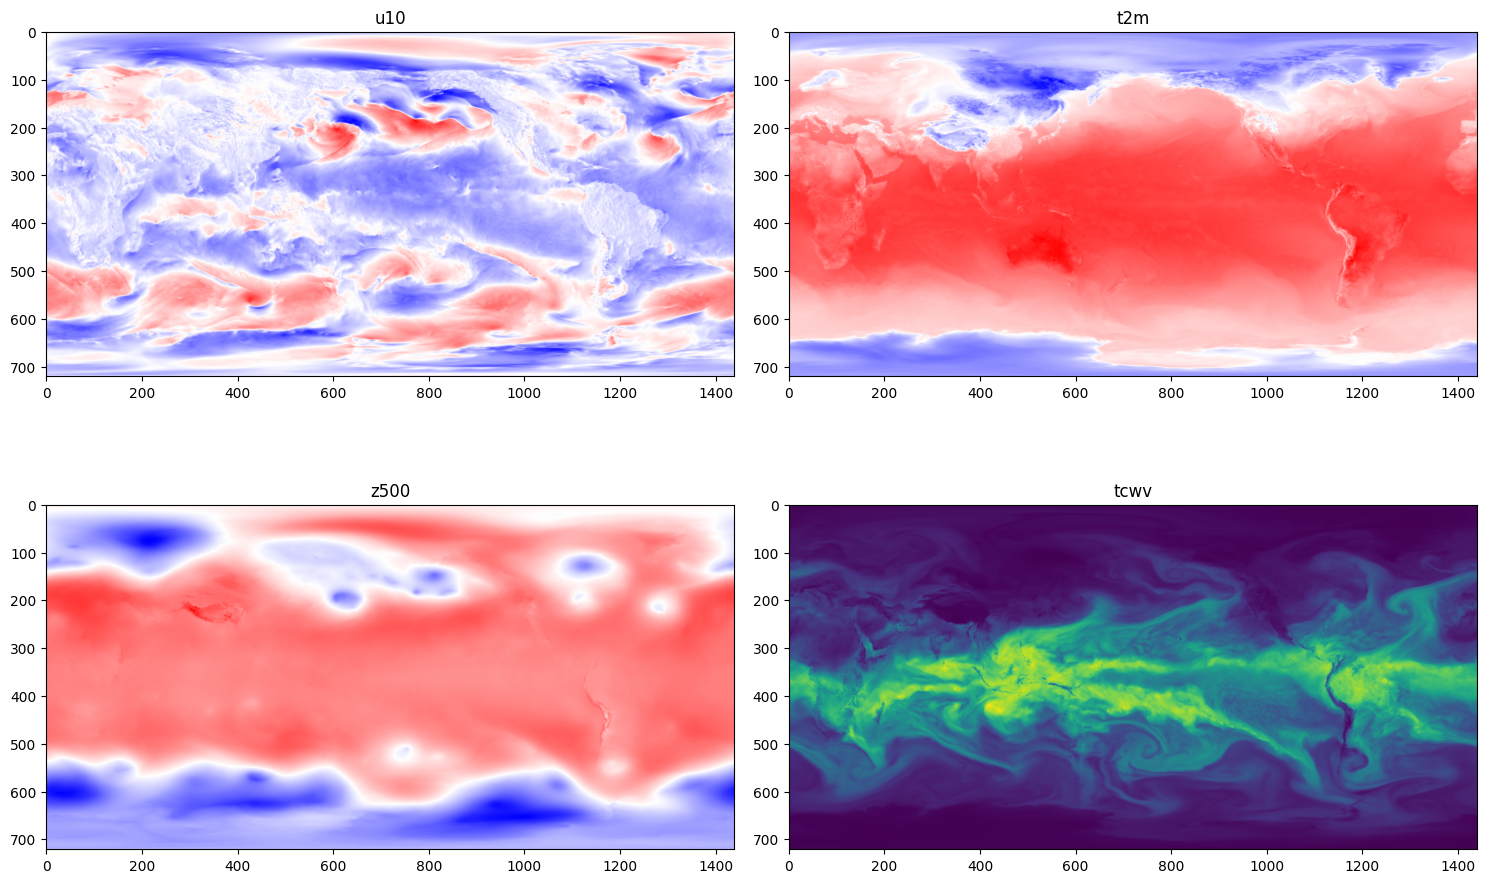

In [20]:
'''
The ordering of atmospheric variables along the channel dimension is as follows:
'''
variables = ['u10',
             'v10',
             't2m',
             'sp',
             'msl',
             't850',
             'u1000',
             'v1000',
             'z1000',
             'u850',
             'v850',
             'z850',
             'u500',
             'v500',
             'z500',
             't500',
             'z50' ,
             'r500',
             'r850',
             'tcwv']

sample_data = h5py.File(data_file, 'r')['fields']
print('Total data shape:', sample_data.shape)
print(len(variables))
timestep_idx = 0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, varname in enumerate(['u10', 't2m', 'z500', 'tcwv']):
    cm = 'bwr' if varname == 'u10' or varname == 'z500' or varname == 't2m' else 'viridis'
    varidx = variables.index(varname)
    ax[i//2][i%2].imshow(sample_data[timestep_idx, varidx], cmap=cm)
    ax[i//2][i%2].set_title(varname)
fig.tight_layout()

In [21]:
# import model
from networks.afnonet import AFNONet
from collections import OrderedDict

def load_model(model, params, checkpoint_file,use_finetuned=False):
    ''' helper function to load model weights '''
    checkpoint_fname = checkpoint_file
    checkpoint = torch.load(checkpoint_fname,weights_only=False)
    try:
        ''' FourCastNet is trained with distributed data parallel
            (DDP) which prepends 'module' to all keys. Non-DDP
            models need to strip this prefix '''
        new_state_dict = OrderedDict()
        for key, val in checkpoint[model_key].items():
            name = key[7:]
            if name != 'ged':
                new_state_dict[name] = val
        model.load_state_dict(new_state_dict)
    except:
        model.load_state_dict(checkpoint[model_key])
        
    if not use_finetuned:
        return model

    try:
        finetuned_checkpoint = torch.load(finetuned_checkpoint_path, weights_only=False)
        
        # 从你的保存结构中提取模型的 state_dict
        # 你的代码是把权重保存在 'model_state' 键下
        finetuned_state_dict = finetuned_checkpoint.get('model_state')

        if finetuned_state_dict is None:
            raise KeyError("在微调检查点文件中找不到 'model_state' 键。")

        # 将微调后的权重加载到模型上。
        # 这一步会用新权重覆盖掉那些在微调中被训练的层（如 norm, head）。
        # 因为 finetuned_state_dict 包含了所有层的参数，所以可以用 strict=True
        model.load_state_dict(finetuned_state_dict, strict=False)
        print("     微调权重覆盖成功。")

    except Exception as e:
        print(f"     错误：加载微调权重时出错: {e}")
        raise
    model.eval() # set to inference mode
    return model

device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

# in and out channels: FourCastNet uses 20 input channels corresponding to 20 prognostic variables
in_channels = np.array(params.in_channels)
out_channels = np.array(params.out_channels)
params['N_in_channels'] = len(in_channels)
params['N_out_channels'] = len(out_channels)
params.means = np.load(global_means_path)[0, out_channels] # for normalizing data with precomputed train stats
params.stds = np.load(global_stds_path)[0, out_channels]
params.time_means = np.load(time_means_path)[0, out_channels]


In [22]:
# load the model
if params.nettype == 'afno':
    model = AFNONet(params).to(device)  # AFNO model
else:
    raise Exception("not implemented")
# load saved model weights
model = load_model(model, params, model_path,True)
model = model.to(device)

     微调权重覆盖成功。


# 数据归一化

In [23]:
# move normalization tensors to gpu
# load time means: represents climatology
img_shape_x = 720
img_shape_y = 1440

# means and stds over training data
means = params.means
stds = params.stds

# load climatological means
time_means = params.time_means # temporal mean (for every pixel)
m = torch.as_tensor((time_means - means)/stds)[:, 0:img_shape_x]
m = torch.unsqueeze(m, 0)
# these are needed to compute ACC and RMSE metrics
m = m.to(device, dtype=torch.float)
std = torch.as_tensor(stds[:,0,0]).to(device, dtype=torch.float)

print("Shape of time means = {}".format(m.shape))
print("Shape of std = {}".format(std.shape))

Shape of time means = torch.Size([1, 20, 720, 1440])
Shape of std = torch.Size([20])


In [24]:
# define metrics from the definitions above
def lat(j: torch.Tensor, num_lat: int) -> torch.Tensor:
    return 90. - j * 180./float(num_lat-1)

def latitude_weighting_factor(j: torch.Tensor, num_lat: int, s: torch.Tensor) -> torch.Tensor:
    return num_lat * torch.cos(3.1416/180. * lat(j, num_lat))/s

def weighted_rmse_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    #takes in arrays of size [n, c, h, w]  and returns latitude-weighted rmse for each channel
    num_lat = pred.shape[2]
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))
    result = torch.sqrt(torch.mean(weight * (pred - target)**2., dim=(-1,-2)))
    return result

def weighted_acc_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    #takes in arrays of size [n, c, h, w]  and returns latitude-weighted acc for each channel
    num_lat = pred.shape[2]
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))
    result = torch.sum(weight * pred * target, dim=(-1,-2)) / torch.sqrt(torch.sum(weight * pred * pred, dim=(-1,-2)) * torch.sum(weight * target *
    target, dim=(-1,-2)))
    return result

In [25]:
# autoregressive inference helper

def inference(data_slice, model, prediction_length, idx):
    # create memory for the different stats
    n_out_channels = params['N_out_channels']
    acc = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    
    rmse = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    
    # ADDED: create memory for Mean Absolute Error (MAE)
    mae = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)

    # to conserve GPU mem, only save one channel (can be changed if sufficient GPU mem or move to CPU)
    targets = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
    predictions = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)


    with torch.no_grad():
        for i in range(data_slice.shape[0]):
            if i == 0:
                first = data_slice[0:1]
                future = data_slice[1:2]
                pred = first
                tar = first
                # also save out predictions for visualizing channel index idx
                targets[0,0] = first[0,idx]
                predictions[0,0] = first[0,idx]
                # predict
                future_pred = model(first)
            else:
                if i < prediction_length - 1:
                    future = data_slice[i+1:i+2]
                future_pred = model(future_pred) # autoregressive step

            if i < prediction_length - 1:
                predictions[i+1,0] = future_pred[0,idx]
                targets[i+1,0] = future[0,idx]

            # compute metrics using the ground truth ERA5 data as "true" predictions
            rmse[i] = weighted_rmse_channels(pred, tar) * std
            acc[i] = weighted_acc_channels(pred-m, tar-m)
            
            # ADDED: Calculate Mean Absolute Error (MAE)
            # 1. Calculate absolute difference between prediction and target
            #    pred and tar have shape: [1, n_out_channels, H, W]
            abs_error = torch.abs(pred - tar)
            
            # 2. Calculate the mean over the spatial dimensions (height and width) for each channel
            #    The result will have shape [1, n_out_channels]
            mae_per_channel = torch.mean(abs_error, dim=(-2, -1))
            
            # 3. Un-normalize by multiplying with std (same as for RMSE) and store it
            #    .squeeze(0) removes the batch dimension of size 1, resulting in shape [n_out_channels]
            mae[i] = mae_per_channel.squeeze(0) * std
            
            print('Predicted timestep {} of {}. {} RMS Error: {}, ACC: {}, MAE: {}'.format(i, prediction_length, field, rmse[i,idx], acc[i,idx],mae[i,idx]))

            pred = future_pred
            tar = future

    # copy to cpu for plotting/vis
    acc_cpu = acc.cpu().numpy()
    rmse_cpu = rmse.cpu().numpy()
    predictions_cpu = predictions.cpu().numpy()
    targets_cpu = targets.cpu().numpy()
    
    # ADDED: copy MAE to CPU
    mae_cpu = mae.cpu().numpy()

    return acc_cpu, rmse_cpu, predictions_cpu, targets_cpu


In [26]:
# setup data for inference
dt = 1 # time step (x 6 hours)
ic = 0 # start the inference from here
prediction_length = 8 # number of steps (x 6 hours)

# which field to track for visualization
field = 't2m' # 这里修改需要推测的域
idx_vis = variables.index(field) # also prints out metrics for this field

# get prediction length slice from the data
print('Loading inference data')
print('Inference data from {}'.format(data_file))
data = h5py.File(data_file, 'r')['fields'][ic:(ic+prediction_length*dt):dt,in_channels,0:img_shape_x]
print(data.shape)
print("Shape of data = {}".format(data.shape))

Loading inference data
Inference data from D:/NCFiles/output/era5_2025_01.h5
(8, 20, 720, 1440)
Shape of data = (8, 20, 720, 1440)


## 推理

In [27]:
# run inference
data = (data - means)/stds # standardize the data
data = torch.as_tensor(data).to(device, dtype=torch.float) # move to gpu for inference
acc_cpu, rmse_cpu, predictions_cpu, targets_cpu = inference(data, model, prediction_length, idx=idx_vis)

Predicted timestep 0 of 8. t2m RMS Error: 0.0, ACC: 1.0, MAE: 0.0
Predicted timestep 1 of 8. t2m RMS Error: 3.474923610687256, ACC: 0.9210180640220642, MAE: 2.771427869796753
Predicted timestep 2 of 8. t2m RMS Error: 3.9471845626831055, ACC: 0.8968096971511841, MAE: 3.3159070014953613
Predicted timestep 3 of 8. t2m RMS Error: 3.988779306411743, ACC: 0.8987501859664917, MAE: 3.6382110118865967
Predicted timestep 4 of 8. t2m RMS Error: 4.344618797302246, ACC: 0.8875249028205872, MAE: 4.038491725921631
Predicted timestep 5 of 8. t2m RMS Error: 4.627920150756836, ACC: 0.8714333176612854, MAE: 4.448044300079346
Predicted timestep 6 of 8. t2m RMS Error: 5.138543605804443, ACC: 0.8482654094696045, MAE: 5.058633327484131
Predicted timestep 7 of 8. t2m RMS Error: 5.658505916595459, ACC: 0.8311026692390442, MAE: 5.759091854095459


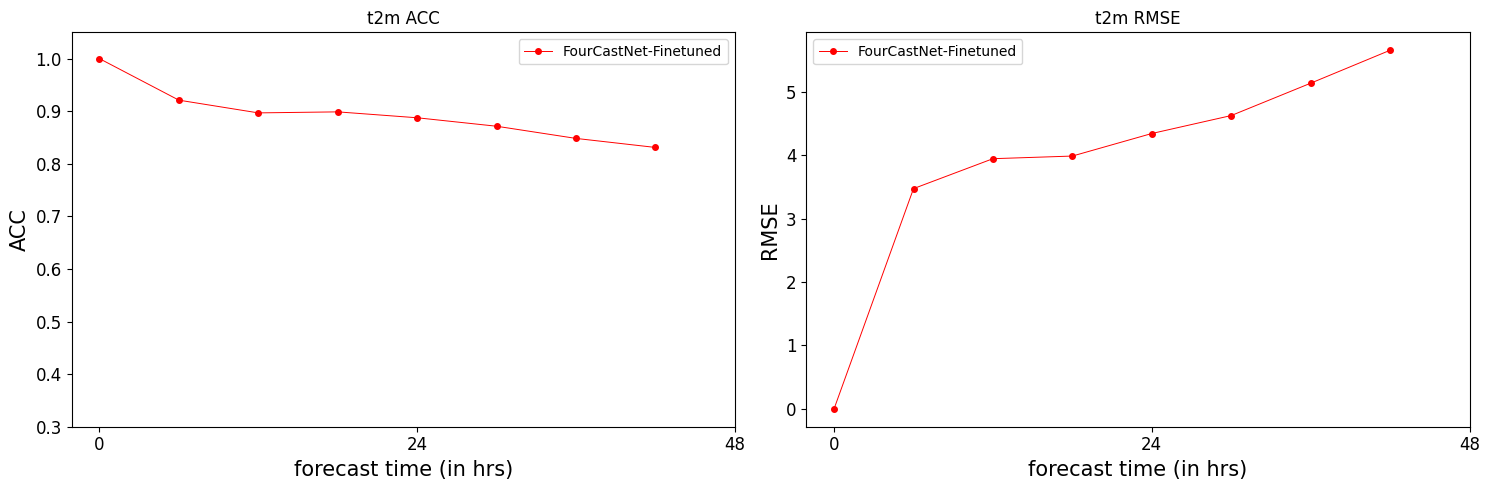

In [28]:
# plot the acc and rmse metrics
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
start = 0
end = prediction_length #  < prediction_lenght forecast

# field = 't2m' # change this to other fields such as z500 这里在先前的单元格已经定义了，不定义保持与前面的一致性
idx_metric = variables.index(field) # plot metrics for this field

hrs = np.arange(0, end*6, 6)
ax[0].plot(hrs, acc_cpu[start:end,idx_metric], "o-", label="FourCastNet-Finetuned", ms=4, lw=0.7, color="r")
ax[1].plot(hrs, rmse_cpu[start:end,idx_metric], "o-", label="FourCastNet-Finetuned", ms=4, lw=0.7, color="r")
ax[0].legend()
ax[1].legend()
fsz = "15"
xlist = np.arange(0,end*6+24,24)
ax[0].set_xlabel("forecast time (in hrs)", fontsize=fsz)
ax[1].set_xlabel("forecast time (in hrs)", fontsize=fsz)
ax[0].set_ylabel("ACC", fontsize=fsz)
ax[1].set_ylabel("RMSE", fontsize=fsz)
ax[0].set_ylim(0.3, 1.05)
ax[0].set_xticks(xlist)
ax[1].set_xticks(xlist)
ax[0].tick_params(axis='both', which='both', labelsize=12)
ax[1].tick_params(axis='both', which='both', labelsize=12)
ax[0].set_title(f"{field} ACC")
ax[1].set_title(f"{field} RMSE")
fig.tight_layout()